/home/sam/miniconda3/envs/fenics-env/lib/python3.11/site-packages/ufl/__init__.py:250: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


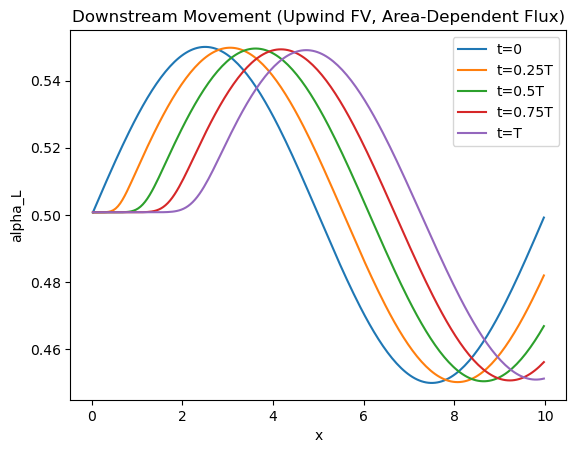

In [1]:
from fenics import *
import numpy as np
import matplotlib.pyplot as plt

set_log_level(30)

N = 200
L = 10.0
mesh = IntervalMesh(N, 0, L)
dx_cell = L / N
u_advection = 20.0
CFL = 0.05
dt = CFL * dx_cell / u_advection
T = 0.05

# Define geometry function (A_L) for each cell
def compute_area(alpha):
    r = 0.05  # pipe radius
    h_int = r * (2 * alpha - 1)
    r2 = r * r
    root_h = np.sqrt(np.maximum(r2 - h_int**2, 0))
    return r2 * np.arccos(-h_int/r) + h_int * root_h

V = FunctionSpace(mesh, "DG", 0)  # FV
x = SpatialCoordinate(mesh)
alpha_L0 = project(0.5 + 0.05 * sin(2 * np.pi * x[0] / L), V)

alpha_L_n = Function(V)
alpha_L_n.assign(alpha_L0)

timesteps = int(T/dt)
all_data = np.zeros((timesteps+1, V.dim()))
cell_centers = np.array([cell.midpoint().x() for cell in cells(mesh)])
all_data[0, :] = alpha_L_n.vector().get_local()

for step in range(1, timesteps+1):
    alpha = alpha_L_n.vector().get_local()

    # Compute local area for each cell (using holdup)
    A_L = compute_area(alpha)

    # Upwind FV for variable area: F_i = A_L[i]*u*alpha[i]
    # Interface flux: upwind, so for positive u, take from left
    F = np.zeros_like(alpha)
    F[1:] = A_L[1:] * u_advection * alpha[1:]
    F[0]  = A_L[0] * u_advection * alpha[0]  # Inflow BC

    F_left = np.zeros_like(alpha)
    F_left[1:] = A_L[:-1] * u_advection * alpha[:-1]
    F_left[0]  = A_L[0] * u_advection * alpha[0]  # Ghost cell BC

    # FV update: d(alpha*A_L)/dt + dF/dx = 0
    # But since A_L is varying, careful with conservation!
    alpha_new = alpha - dt/dx_cell * (F - F_left) / (A_L + 1e-12)

    alpha_L_n.vector().set_local(alpha_new)
    all_data[step, :] = alpha_new

plt.figure()
for frac, label in zip([0, 0.25, 0.5, 0.75, 1.0], ['t=0', 't=0.25T', 't=0.5T', 't=0.75T', 't=T']):
    idx = int(frac * timesteps)
    plt.plot(cell_centers, all_data[idx, :], label=label)
plt.xlabel('x')
plt.ylabel('alpha_L')
plt.legend()
plt.title("Downstream Movement (Upwind FV, Area-Dependent Flux)")
plt.show()


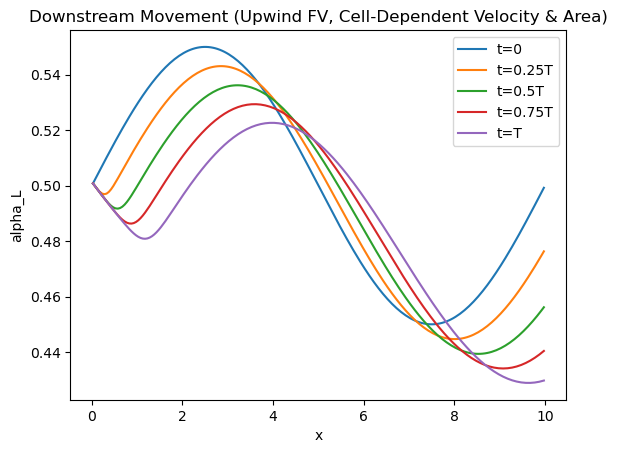

In [2]:
from fenics import *
import numpy as np
import matplotlib.pyplot as plt

set_log_level(30)

N = 200
L = 10.0
mesh = IntervalMesh(N, 0, L)
dx_cell = L / N
CFL = 0.05
T = 0.05

# Example: spatially varying velocity (here, just a ramp—can be arbitrary)
cell_centers = np.array([cell.midpoint().x() for cell in cells(mesh)])
u_advection = 10.0 + 10.0 * (cell_centers / L)  # From 10 to 20 m/s

dt = CFL * dx_cell / np.max(np.abs(u_advection))  # Use max velocity for CFL
timesteps = int(T/dt)

# Define geometry function (A_L) for each cell
def compute_area(alpha):
    r = 0.05  # pipe radius
    h_int = r * (2 * alpha - 1)
    r2 = r * r
    root_h = np.sqrt(np.maximum(r2 - h_int**2, 0))
    return r2 * np.arccos(-h_int/r) + h_int * root_h

V = FunctionSpace(mesh, "DG", 0)  # FV
x = SpatialCoordinate(mesh)
alpha_L0 = project(0.5 + 0.05 * sin(2 * np.pi * x[0] / L), V)

alpha_L_n = Function(V)
alpha_L_n.assign(alpha_L0)

all_data = np.zeros((timesteps+1, V.dim()))
all_data[0, :] = alpha_L_n.vector().get_local()

for step in range(1, timesteps+1):
    alpha = alpha_L_n.vector().get_local()
    A_L = compute_area(alpha)

    # Upwind FV for variable area/velocity: F_i = A_L[i]*u[i]*alpha[i]
    F = np.zeros_like(alpha)
    F[1:] = A_L[1:] * u_advection[1:] * alpha[1:]
    F[0]  = A_L[0] * u_advection[0] * alpha[0]  # Inflow BC

    F_left = np.zeros_like(alpha)
    F_left[1:] = A_L[:-1] * u_advection[:-1] * alpha[:-1]
    F_left[0]  = A_L[0] * u_advection[0] * alpha[0]  # Ghost cell BC

    # FV update: d(alpha*A_L)/dt + dF/dx = 0
    alpha_new = alpha - dt/dx_cell * (F - F_left) / (A_L + 1e-12)

    alpha_L_n.vector().set_local(alpha_new)
    all_data[step, :] = alpha_new

plt.figure()
for frac, label in zip([0, 0.25, 0.5, 0.75, 1.0], ['t=0', 't=0.25T', 't=0.5T', 't=0.75T', 't=T']):
    idx = int(frac * timesteps)
    plt.plot(cell_centers, all_data[idx, :], label=label)
plt.xlabel('x')
plt.ylabel('alpha_L')
plt.legend()
plt.title("Downstream Movement (Upwind FV, Cell-Dependent Velocity & Area)")
plt.show()


Calling FFC just-in-time (JIT) compiler, this may take some time.


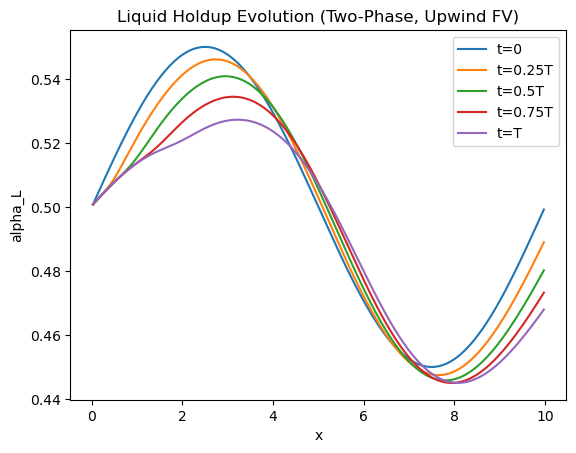

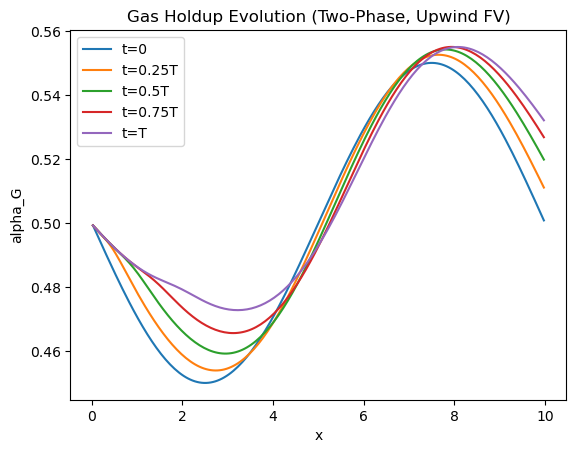

In [3]:
from fenics import *
import numpy as np
import matplotlib.pyplot as plt

set_log_level(30)

N = 200
L = 10.0
mesh = IntervalMesh(N, 0, L)
dx_cell = L / N
CFL = 0.05
T = 0.05

cell_centers = np.array([cell.midpoint().x() for cell in cells(mesh)])

# Independent velocities for each phase (can be functions of x, or constant)
u_L = 10.0 + 10.0 * (cell_centers / L)     # From 10 to 20 m/s
u_G = 20.0 + 5.0 * np.sin(2 * np.pi * cell_centers / L)  # A little wavy

dt = CFL * dx_cell / np.max([np.max(np.abs(u_L)), np.max(np.abs(u_G))])
timesteps = int(T/dt)

# Initial holdup profiles
V = FunctionSpace(mesh, "DG", 0)
x = SpatialCoordinate(mesh)
alpha_L0 = project(0.5 + 0.05 * sin(2 * np.pi * x[0] / L), V)
alpha_G0 = project(1.0 - (0.5 + 0.05 * sin(2 * np.pi * x[0] / L)), V)

alpha_L_n = Function(V)
alpha_G_n = Function(V)
alpha_L_n.assign(alpha_L0)
alpha_G_n.assign(alpha_G0)

all_data_L = np.zeros((timesteps+1, V.dim()))
all_data_G = np.zeros((timesteps+1, V.dim()))
all_data_L[0, :] = alpha_L_n.vector().get_local()
all_data_G[0, :] = alpha_G_n.vector().get_local()

# Geometry function, same as before
def compute_area(alpha):
    r = 0.05
    h_int = r * (2 * alpha - 1)
    r2 = r * r
    root_h = np.sqrt(np.maximum(r2 - h_int**2, 0))
    return r2 * np.arccos(-h_int/r) + h_int * root_h

for step in range(1, timesteps+1):
    alpha_L = alpha_L_n.vector().get_local()
    alpha_G = alpha_G_n.vector().get_local()

    # Areas for each phase (can do something more advanced later)
    A_L = compute_area(alpha_L)
    A_G = compute_area(alpha_G)  # For closure, could use 1-A_L or another function

    # Upwind FV for both phases
    # ---- Liquid ----
    F_L = np.zeros_like(alpha_L)
    F_L[1:] = A_L[1:] * u_L[1:] * alpha_L[1:]
    F_L[0]  = A_L[0]  * u_L[0]  * alpha_L[0]

    F_L_left = np.zeros_like(alpha_L)
    F_L_left[1:] = A_L[:-1] * u_L[:-1] * alpha_L[:-1]
    F_L_left[0]  = A_L[0]  * u_L[0]  * alpha_L[0]

    alpha_L_new = alpha_L - dt/dx_cell * (F_L - F_L_left) / (A_L + 1e-12)

    # ---- Gas ----
    F_G = np.zeros_like(alpha_G)
    F_G[1:] = A_G[1:] * u_G[1:] * alpha_G[1:]
    F_G[0]  = A_G[0]  * u_G[0]  * alpha_G[0]

    F_G_left = np.zeros_like(alpha_G)
    F_G_left[1:] = A_G[:-1] * u_G[:-1] * alpha_G[:-1]
    F_G_left[0]  = A_G[0]  * u_G[0]  * alpha_G[0]

    alpha_G_new = alpha_G - dt/dx_cell * (F_G - F_G_left) / (A_G + 1e-12)

    # Enforce closure (option 1: projection)
    sum_holdup = alpha_L_new + alpha_G_new
    alpha_L_new /= (sum_holdup + 1e-12)
    alpha_G_new /= (sum_holdup + 1e-12)

    alpha_L_n.vector().set_local(alpha_L_new)
    alpha_G_n.vector().set_local(alpha_G_new)
    all_data_L[step, :] = alpha_L_new
    all_data_G[step, :] = alpha_G_new

# Plot both holdups
plt.figure()
for frac, label in zip([0, 0.25, 0.5, 0.75, 1.0], ['t=0', 't=0.25T', 't=0.5T', 't=0.75T', 't=T']):
    idx = int(frac * timesteps)
    plt.plot(cell_centers, all_data_L[idx, :], label=label)
plt.xlabel('x')
plt.ylabel('alpha_L')
plt.legend()
plt.title("Liquid Holdup Evolution (Two-Phase, Upwind FV)")
plt.show()

plt.figure()
for frac, label in zip([0, 0.25, 0.5, 0.75, 1.0], ['t=0', 't=0.25T', 't=0.5T', 't=0.75T', 't=T']):
    idx = int(frac * timesteps)
    plt.plot(cell_centers, all_data_G[idx, :], label=label)
plt.xlabel('x')
plt.ylabel('alpha_G')
plt.legend()
plt.title("Gas Holdup Evolution (Two-Phase, Upwind FV)")
plt.show()


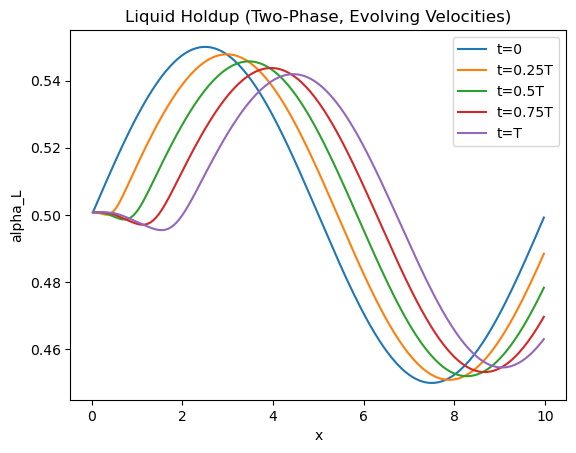

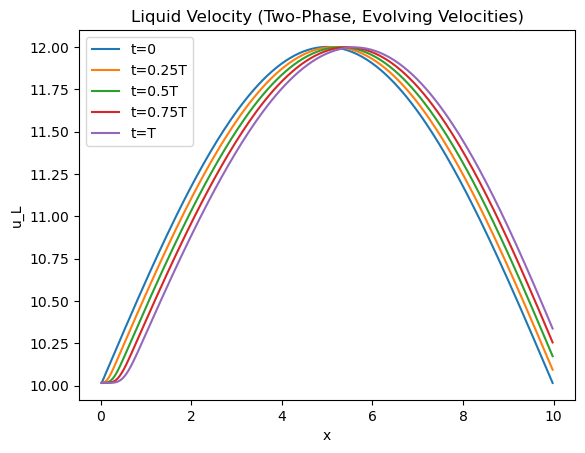

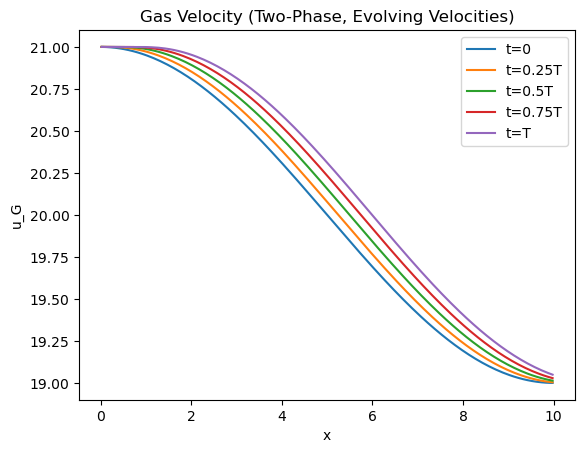

In [4]:
from fenics import *
import numpy as np
import matplotlib.pyplot as plt

set_log_level(30)

N = 200
L = 10.0
mesh = IntervalMesh(N, 0, L)
dx_cell = L / N
CFL = 0.05
T = 0.05

cell_centers = np.array([cell.midpoint().x() for cell in cells(mesh)])

# Initial holdup profiles
V = FunctionSpace(mesh, "DG", 0)
x = SpatialCoordinate(mesh)
alpha_L0 = project(0.5 + 0.05 * sin(2 * np.pi * x[0] / L), V)
alpha_G0 = project(1.0 - (0.5 + 0.05 * sin(2 * np.pi * x[0] / L)), V)

# Initial velocities (perturbed or constant)
u_L0 = 10.0 + 2.0 * np.sin(np.pi * cell_centers / L)
u_G0 = 20.0 + 1.0 * np.cos(np.pi * cell_centers / L)

dt = CFL * dx_cell / np.max([np.max(np.abs(u_L0)), np.max(np.abs(u_G0))])
timesteps = int(T/dt)

alpha_L_n = Function(V)
alpha_G_n = Function(V)
alpha_L_n.assign(alpha_L0)
alpha_G_n.assign(alpha_G0)
u_L_n = u_L0.copy()
u_G_n = u_G0.copy()

all_data_L = np.zeros((timesteps+1, V.dim()))
all_data_G = np.zeros((timesteps+1, V.dim()))
all_data_uL = np.zeros((timesteps+1, V.dim()))
all_data_uG = np.zeros((timesteps+1, V.dim()))
all_data_L[0, :] = alpha_L_n.vector().get_local()
all_data_G[0, :] = alpha_G_n.vector().get_local()
all_data_uL[0, :] = u_L_n
all_data_uG[0, :] = u_G_n

def compute_area(alpha):
    r = 0.05
    h_int = r * (2 * alpha - 1)
    r2 = r * r
    root_h = np.sqrt(np.maximum(r2 - h_int**2, 0))
    return r2 * np.arccos(-h_int/r) + h_int * root_h

for step in range(1, timesteps+1):
    alpha_L = alpha_L_n.vector().get_local()
    alpha_G = alpha_G_n.vector().get_local()
    u_L = u_L_n.copy()
    u_G = u_G_n.copy()

    # Compute local areas
    A_L = compute_area(alpha_L)
    A_G = compute_area(alpha_G)

    # ---- ADVECT HOLDUPS ----
    # Liquid
    F_L = np.zeros_like(alpha_L)
    F_L[1:] = A_L[1:] * u_L[1:] * alpha_L[1:]
    F_L[0]  = A_L[0]  * u_L[0]  * alpha_L[0]

    F_L_left = np.zeros_like(alpha_L)
    F_L_left[1:] = A_L[:-1] * u_L[:-1] * alpha_L[:-1]
    F_L_left[0]  = A_L[0]  * u_L[0]  * alpha_L[0]

    alpha_L_new = alpha_L - dt/dx_cell * (F_L - F_L_left) / (A_L + 1e-12)

    # Gas
    F_G = np.zeros_like(alpha_G)
    F_G[1:] = A_G[1:] * u_G[1:] * alpha_G[1:]
    F_G[0]  = A_G[0]  * u_G[0]  * alpha_G[0]

    F_G_left = np.zeros_like(alpha_G)
    F_G_left[1:] = A_G[:-1] * u_G[:-1] * alpha_G[:-1]
    F_G_left[0]  = A_G[0]  * u_G[0]  * alpha_G[0]

    alpha_G_new = alpha_G - dt/dx_cell * (F_G - F_G_left) / (A_G + 1e-12)

    # ---- ADVECT MOMENTUM (VELOCITY) ----
    # For each phase, conservative update: (α u)
    # For now, ignore pressure and drag
    # Liquid
    m_L = alpha_L * u_L
    Fm_L = np.zeros_like(m_L)
    Fm_L[1:] = A_L[1:] * (u_L[1:]**2) * alpha_L[1:]
    Fm_L[0]  = A_L[0] * (u_L[0]**2) * alpha_L[0]

    Fm_L_left = np.zeros_like(m_L)
    Fm_L_left[1:] = A_L[:-1] * (u_L[:-1]**2) * alpha_L[:-1]
    Fm_L_left[0]  = A_L[0] * (u_L[0]**2) * alpha_L[0]

    m_L_new = m_L - dt/dx_cell * (Fm_L - Fm_L_left) / (A_L + 1e-12)
    # Avoid division by zero
    u_L_new = np.where(alpha_L_new > 1e-12, m_L_new / (alpha_L_new + 1e-12), 0.0)

    # Gas
    m_G = alpha_G * u_G
    Fm_G = np.zeros_like(m_G)
    Fm_G[1:] = A_G[1:] * (u_G[1:]**2) * alpha_G[1:]
    Fm_G[0]  = A_G[0] * (u_G[0]**2) * alpha_G[0]

    Fm_G_left = np.zeros_like(m_G)
    Fm_G_left[1:] = A_G[:-1] * (u_G[:-1]**2) * alpha_G[:-1]
    Fm_G_left[0]  = A_G[0] * (u_G[0]**2) * alpha_G[0]

    m_G_new = m_G - dt/dx_cell * (Fm_G - Fm_G_left) / (A_G + 1e-12)
    u_G_new = np.where(alpha_G_new > 1e-12, m_G_new / (alpha_G_new + 1e-12), 0.0)

    # ---- ENFORCE CLOSURE ----
    sum_holdup = alpha_L_new + alpha_G_new
    alpha_L_new /= (sum_holdup + 1e-12)
    alpha_G_new /= (sum_holdup + 1e-12)

    # Save and update
    alpha_L_n.vector().set_local(alpha_L_new)
    alpha_G_n.vector().set_local(alpha_G_new)
    u_L_n = u_L_new
    u_G_n = u_G_new
    all_data_L[step, :] = alpha_L_new
    all_data_G[step, :] = alpha_G_new
    all_data_uL[step, :] = u_L_new
    all_data_uG[step, :] = u_G_new

# Plot holdup
plt.figure()
for frac, label in zip([0, 0.25, 0.5, 0.75, 1.0], ['t=0', 't=0.25T', 't=0.5T', 't=0.75T', 't=T']):
    idx = int(frac * timesteps)
    plt.plot(cell_centers, all_data_L[idx, :], label=label)
plt.xlabel('x')
plt.ylabel('alpha_L')
plt.legend()
plt.title("Liquid Holdup (Two-Phase, Evolving Velocities)")
plt.show()

# Plot velocities
plt.figure()
for frac, label in zip([0, 0.25, 0.5, 0.75, 1.0], ['t=0', 't=0.25T', 't=0.5T', 't=0.75T', 't=T']):
    idx = int(frac * timesteps)
    plt.plot(cell_centers, all_data_uL[idx, :], label=label)
plt.xlabel('x')
plt.ylabel('u_L')
plt.legend()
plt.title("Liquid Velocity (Two-Phase, Evolving Velocities)")
plt.show()

plt.figure()
for frac, label in zip([0, 0.25, 0.5, 0.75, 1.0], ['t=0', 't=0.25T', 't=0.5T', 't=0.75T', 't=T']):
    idx = int(frac * timesteps)
    plt.plot(cell_centers, all_data_uG[idx, :], label=label)
plt.xlabel('x')
plt.ylabel('u_G')
plt.legend()
plt.title("Gas Velocity (Two-Phase, Evolving Velocities)")
plt.show()


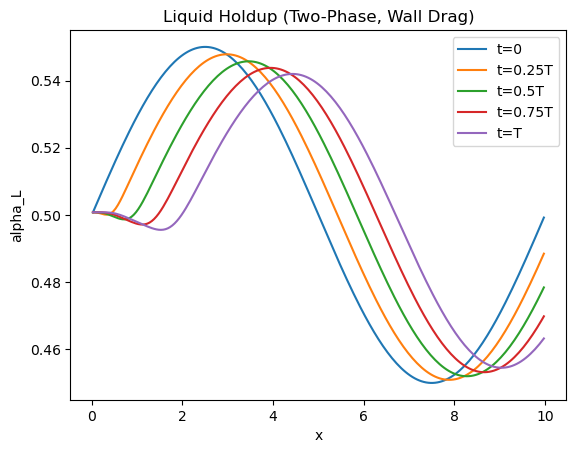

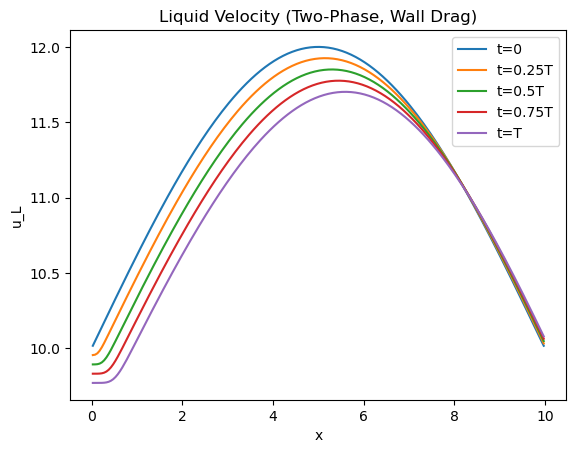

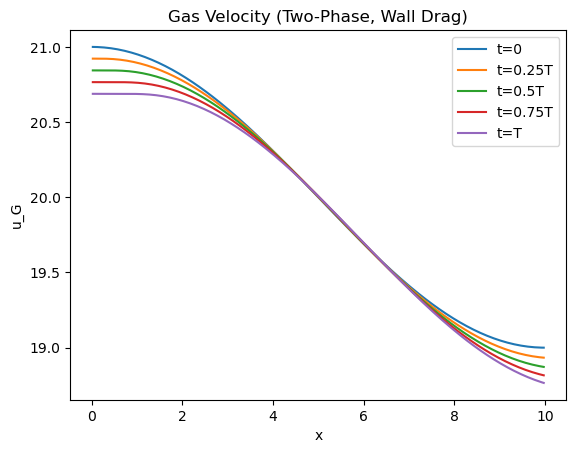

In [6]:
from fenics import *
import numpy as np
import matplotlib.pyplot as plt

set_log_level(30)

N = 200
L = 10.0
mesh = IntervalMesh(N, 0, L)
dx_cell = L / N
CFL = 0.05
T = 0.05

cell_centers = np.array([cell.midpoint().x() for cell in cells(mesh)])

# Initial holdup profiles
V = FunctionSpace(mesh, "DG", 0)
x = SpatialCoordinate(mesh)
alpha_L0 = project(0.5 + 0.05 * sin(2 * np.pi * x[0] / L), V)
alpha_G0 = project(1.0 - (0.5 + 0.05 * sin(2 * np.pi * x[0] / L)), V)

# Initial velocities
u_L0 = 10.0 + 2.0 * np.sin(np.pi * cell_centers / L)
u_G0 = 20.0 + 1.0 * np.cos(np.pi * cell_centers / L)

dt = CFL * dx_cell / np.max([np.max(np.abs(u_L0)), np.max(np.abs(u_G0))])
timesteps = int(T/dt)

alpha_L_n = Function(V)
alpha_G_n = Function(V)
alpha_L_n.assign(alpha_L0)
alpha_G_n.assign(alpha_G0)
u_L_n = u_L0.copy()
u_G_n = u_G0.copy()

all_data_L = np.zeros((timesteps+1, V.dim()))
all_data_G = np.zeros((timesteps+1, V.dim()))
all_data_uL = np.zeros((timesteps+1, V.dim()))
all_data_uG = np.zeros((timesteps+1, V.dim()))
all_data_L[0, :] = alpha_L_n.vector().get_local()
all_data_G[0, :] = alpha_G_n.vector().get_local()
all_data_uL[0, :] = u_L_n
all_data_uG[0, :] = u_G_n

def compute_area(alpha):
    r = 0.05
    h_int = r * (2 * alpha - 1)
    r2 = r * r
    root_h = np.sqrt(np.maximum(r2 - h_int**2, 0))
    return r2 * np.arccos(-h_int/r) + h_int * root_h

# --- Wall drag coefficients ---
C_wall_L = 0.5  # 1/s, tune as needed
C_wall_G = 0.3  # 1/s

for step in range(1, timesteps+1):
    alpha_L = alpha_L_n.vector().get_local()
    alpha_G = alpha_G_n.vector().get_local()
    u_L = u_L_n.copy()
    u_G = u_G_n.copy()

    # Compute local areas
    A_L = compute_area(alpha_L)
    A_G = compute_area(alpha_G)

    # ---- ADVECT HOLDUPS ----
    # Liquid
    F_L = np.zeros_like(alpha_L)
    F_L[1:] = A_L[1:] * u_L[1:] * alpha_L[1:]
    F_L[0]  = A_L[0]  * u_L[0]  * alpha_L[0]

    F_L_left = np.zeros_like(alpha_L)
    F_L_left[1:] = A_L[:-1] * u_L[:-1] * alpha_L[:-1]
    F_L_left[0]  = A_L[0]  * u_L[0]  * alpha_L[0]

    alpha_L_new = alpha_L - dt/dx_cell * (F_L - F_L_left) / (A_L + 1e-12)

    # Gas
    F_G = np.zeros_like(alpha_G)
    F_G[1:] = A_G[1:] * u_G[1:] * alpha_G[1:]
    F_G[0]  = A_G[0]  * u_G[0]  * alpha_G[0]

    F_G_left = np.zeros_like(alpha_G)
    F_G_left[1:] = A_G[:-1] * u_G[:-1] * alpha_G[:-1]
    F_G_left[0]  = A_G[0]  * u_G[0]  * alpha_G[0]

    alpha_G_new = alpha_G - dt/dx_cell * (F_G - F_G_left) / (A_G + 1e-12)

    # ---- ADVECT AND DAMPEN MOMENTUM ----
    # Liquid
    m_L = alpha_L * u_L
    Fm_L = np.zeros_like(m_L)
    Fm_L[1:] = A_L[1:] * (u_L[1:]**2) * alpha_L[1:]
    Fm_L[0]  = A_L[0] * (u_L[0]**2) * alpha_L[0]

    Fm_L_left = np.zeros_like(m_L)
    Fm_L_left[1:] = A_L[:-1] * (u_L[:-1]**2) * alpha_L[:-1]
    Fm_L_left[0]  = A_L[0] * (u_L[0]**2) * alpha_L[0]

    # Wall drag: -C_wall_L * u_L
    m_L_new = m_L - dt/dx_cell * (Fm_L - Fm_L_left) / (A_L + 1e-12) - dt * C_wall_L * m_L
    u_L_new = np.where(alpha_L_new > 1e-12, m_L_new / (alpha_L_new + 1e-12), 0.0)

    # Gas
    m_G = alpha_G * u_G
    Fm_G = np.zeros_like(m_G)
    Fm_G[1:] = A_G[1:] * (u_G[1:]**2) * alpha_G[1:]
    Fm_G[0]  = A_G[0] * (u_G[0]**2) * alpha_G[0]

    Fm_G_left = np.zeros_like(m_G)
    Fm_G_left[1:] = A_G[:-1] * (u_G[:-1]**2) * alpha_G[:-1]
    Fm_G_left[0]  = A_G[0] * (u_G[0]**2) * alpha_G[0]

    # Wall drag: -C_wall_G * u_G
    m_G_new = m_G - dt/dx_cell * (Fm_G - Fm_G_left) / (A_G + 1e-12) - dt * C_wall_G * m_G
    u_G_new = np.where(alpha_G_new > 1e-12, m_G_new / (alpha_G_new + 1e-12), 0.0)

    # ---- ENFORCE CLOSURE ----
    sum_holdup = alpha_L_new + alpha_G_new
    alpha_L_new /= (sum_holdup + 1e-12)
    alpha_G_new /= (sum_holdup + 1e-12)

    # Save and update
    alpha_L_n.vector().set_local(alpha_L_new)
    alpha_G_n.vector().set_local(alpha_G_new)
    u_L_n = u_L_new
    u_G_n = u_G_new
    all_data_L[step, :] = alpha_L_new
    all_data_G[step, :] = alpha_G_new
    all_data_uL[step, :] = u_L_new
    all_data_uG[step, :] = u_G_new

# Plot holdup
plt.figure()
for frac, label in zip([0, 0.25, 0.5, 0.75, 1.0], ['t=0', 't=0.25T', 't=0.5T', 't=0.75T', 't=T']):
    idx = int(frac * timesteps)
    plt.plot(cell_centers, all_data_L[idx, :], label=label)
plt.xlabel('x')
plt.ylabel('alpha_L')
plt.legend()
plt.title("Liquid Holdup (Two-Phase, Wall Drag)")
plt.show()

# Plot velocities
plt.figure()
for frac, label in zip([0, 0.25, 0.5, 0.75, 1.0], ['t=0', 't=0.25T', 't=0.5T', 't=0.75T', 't=T']):
    idx = int(frac * timesteps)
    plt.plot(cell_centers, all_data_uL[idx, :], label=label)
plt.xlabel('x')
plt.ylabel('u_L')
plt.legend()
plt.title("Liquid Velocity (Two-Phase, Wall Drag)")
plt.show()

plt.figure()
for frac, label in zip([0, 0.25, 0.5, 0.75, 1.0], ['t=0', 't=0.25T', 't=0.5T', 't=0.75T', 't=T']):
    idx = int(frac * timesteps)
    plt.plot(cell_centers, all_data_uG[idx, :], label=label)
plt.xlabel('x')
plt.ylabel('u_G')
plt.legend()
plt.title("Gas Velocity (Two-Phase, Wall Drag)")
plt.show()


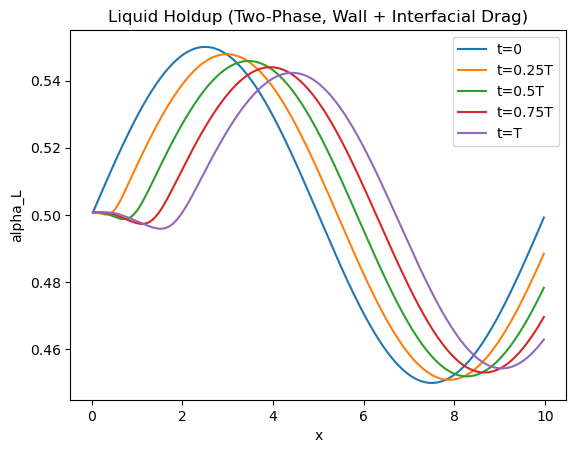

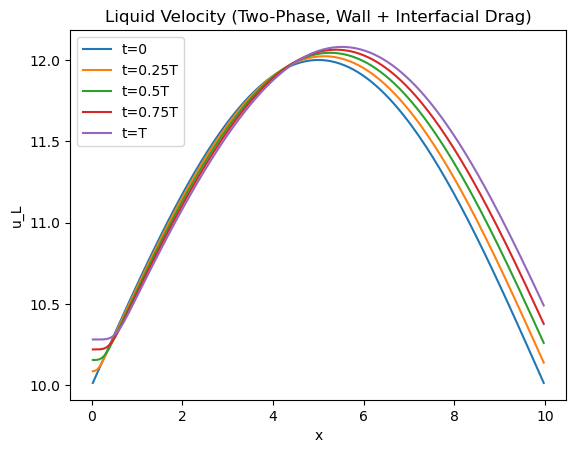

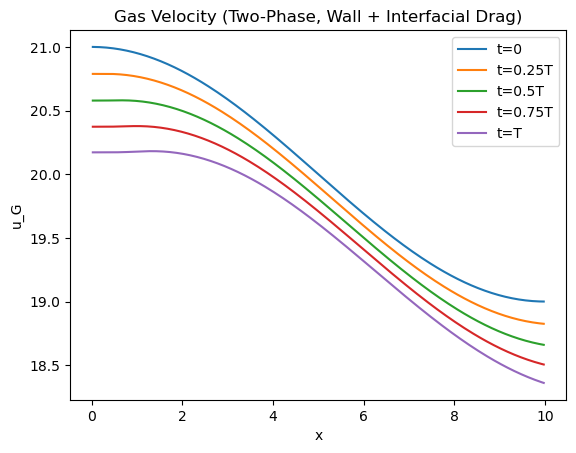

In [8]:
from fenics import *
import numpy as np
import matplotlib.pyplot as plt

set_log_level(30)

N = 200
L = 10.0
mesh = IntervalMesh(N, 0, L)
dx_cell = L / N
CFL = 0.05
T = 0.05

cell_centers = np.array([cell.midpoint().x() for cell in cells(mesh)])

# Initial holdup profiles
V = FunctionSpace(mesh, "DG", 0)
x = SpatialCoordinate(mesh)
alpha_L0 = project(0.5 + 0.05 * sin(2 * np.pi * x[0] / L), V)
alpha_G0 = project(1.0 - (0.5 + 0.05 * sin(2 * np.pi * x[0] / L)), V)

# Initial velocities
u_L0 = 10.0 + 2.0 * np.sin(np.pi * cell_centers / L)
u_G0 = 20.0 + 1.0 * np.cos(np.pi * cell_centers / L)

dt = CFL * dx_cell / np.max([np.max(np.abs(u_L0)), np.max(np.abs(u_G0))])
timesteps = int(T/dt)

alpha_L_n = Function(V)
alpha_G_n = Function(V)
alpha_L_n.assign(alpha_L0)
alpha_G_n.assign(alpha_G0)
u_L_n = u_L0.copy()
u_G_n = u_G0.copy()

all_data_L = np.zeros((timesteps+1, V.dim()))
all_data_G = np.zeros((timesteps+1, V.dim()))
all_data_uL = np.zeros((timesteps+1, V.dim()))
all_data_uG = np.zeros((timesteps+1, V.dim()))
all_data_L[0, :] = alpha_L_n.vector().get_local()
all_data_G[0, :] = alpha_G_n.vector().get_local()
all_data_uL[0, :] = u_L_n
all_data_uG[0, :] = u_G_n

def compute_area(alpha):
    r = 0.05
    h_int = r * (2 * alpha - 1)
    r2 = r * r
    root_h = np.sqrt(np.maximum(r2 - h_int**2, 0))
    return r2 * np.arccos(-h_int/r) + h_int * root_h

# --- Wall and interfacial drag coefficients ---
C_wall_L = 0.5  # 1/s, tune as needed
C_wall_G = 0.3  # 1/s
C_int = 1.0     # 1/s, interfacial drag strength (try 0.5-2.0 for effect)

for step in range(1, timesteps+1):
    alpha_L = alpha_L_n.vector().get_local()
    alpha_G = alpha_G_n.vector().get_local()
    u_L = u_L_n.copy()
    u_G = u_G_n.copy()

    # Compute local areas
    A_L = compute_area(alpha_L)
    A_G = compute_area(alpha_G)

    # ---- ADVECT HOLDUPS ----
    # Liquid
    F_L = np.zeros_like(alpha_L)
    F_L[1:] = A_L[1:] * u_L[1:] * alpha_L[1:]
    F_L[0]  = A_L[0]  * u_L[0]  * alpha_L[0]

    F_L_left = np.zeros_like(alpha_L)
    F_L_left[1:] = A_L[:-1] * u_L[:-1] * alpha_L[:-1]
    F_L_left[0]  = A_L[0]  * u_L[0]  * alpha_L[0]

    alpha_L_new = alpha_L - dt/dx_cell * (F_L - F_L_left) / (A_L + 1e-12)

    # Gas
    F_G = np.zeros_like(alpha_G)
    F_G[1:] = A_G[1:] * u_G[1:] * alpha_G[1:]
    F_G[0]  = A_G[0]  * u_G[0]  * alpha_G[0]

    F_G_left = np.zeros_like(alpha_G)
    F_G_left[1:] = A_G[:-1] * u_G[:-1] * alpha_G[:-1]
    F_G_left[0]  = A_G[0]  * u_G[0]  * alpha_G[0]

    alpha_G_new = alpha_G - dt/dx_cell * (F_G - F_G_left) / (A_G + 1e-12)

    # ---- ADVECT AND DAMPEN MOMENTUM ----
    # Liquid
    m_L = alpha_L * u_L
    Fm_L = np.zeros_like(m_L)
    Fm_L[1:] = A_L[1:] * (u_L[1:]**2) * alpha_L[1:]
    Fm_L[0]  = A_L[0] * (u_L[0]**2) * alpha_L[0]

    Fm_L_left = np.zeros_like(m_L)
    Fm_L_left[1:] = A_L[:-1] * (u_L[:-1]**2) * alpha_L[:-1]
    Fm_L_left[0]  = A_L[0] * (u_L[0]**2) * alpha_L[0]

    # Wall drag: -C_wall_L * u_L
    # Interfacial drag: +C_int * (u_G - u_L)
    m_L_new = m_L - dt/dx_cell * (Fm_L - Fm_L_left) / (A_L + 1e-12) \
              - dt * C_wall_L * m_L \
              + dt * C_int * alpha_L * (u_G - u_L)
    u_L_new = np.where(alpha_L_new > 1e-12, m_L_new / (alpha_L_new + 1e-12), 0.0)

    # Gas
    m_G = alpha_G * u_G
    Fm_G = np.zeros_like(m_G)
    Fm_G[1:] = A_G[1:] * (u_G[1:]**2) * alpha_G[1:]
    Fm_G[0]  = A_G[0] * (u_G[0]**2) * alpha_G[0]

    Fm_G_left = np.zeros_like(m_G)
    Fm_G_left[1:] = A_G[:-1] * (u_G[:-1]**2) * alpha_G[:-1]
    Fm_G_left[0]  = A_G[0] * (u_G[0]**2) * alpha_G[0]

    # Wall drag: -C_wall_G * u_G
    # Interfacial drag: -C_int * (u_G - u_L)
    m_G_new = m_G - dt/dx_cell * (Fm_G - Fm_G_left) / (A_G + 1e-12) \
              - dt * C_wall_G * m_G \
              - dt * C_int * alpha_G * (u_G - u_L)
    u_G_new = np.where(alpha_G_new > 1e-12, m_G_new / (alpha_G_new + 1e-12), 0.0)

    # ---- ENFORCE CLOSURE ----
    sum_holdup = alpha_L_new + alpha_G_new
    alpha_L_new /= (sum_holdup + 1e-12)
    alpha_G_new /= (sum_holdup + 1e-12)

    # Save and update
    alpha_L_n.vector().set_local(alpha_L_new)
    alpha_G_n.vector().set_local(alpha_G_new)
    u_L_n = u_L_new
    u_G_n = u_G_new
    all_data_L[step, :] = alpha_L_new
    all_data_G[step, :] = alpha_G_new
    all_data_uL[step, :] = u_L_new
    all_data_uG[step, :] = u_G_new

# Plot holdup
plt.figure()
for frac, label in zip([0, 0.25, 0.5, 0.75, 1.0], ['t=0', 't=0.25T', 't=0.5T', 't=0.75T', 't=T']):
    idx = int(frac * timesteps)
    plt.plot(cell_centers, all_data_L[idx, :], label=label)
plt.xlabel('x')
plt.ylabel('alpha_L')
plt.legend()
plt.title("Liquid Holdup (Two-Phase, Wall + Interfacial Drag)")
plt.show()

# Plot velocities
plt.figure()
for frac, label in zip([0, 0.25, 0.5, 0.75, 1.0], ['t=0', 't=0.25T', 't=0.5T', 't=0.75T', 't=T']):
    idx = int(frac * timesteps)
    plt.plot(cell_centers, all_data_uL[idx, :], label=label)
plt.xlabel('x')
plt.ylabel('u_L')
plt.legend()
plt.title("Liquid Velocity (Two-Phase, Wall + Interfacial Drag)")
plt.show()

plt.figure()
for frac, label in zip([0, 0.25, 0.5, 0.75, 1.0], ['t=0', 't=0.25T', 't=0.5T', 't=0.75T', 't=T']):
    idx = int(frac * timesteps)
    plt.plot(cell_centers, all_data_uG[idx, :], label=label)
plt.xlabel('x')
plt.ylabel('u_G')
plt.legend()
plt.title("Gas Velocity (Two-Phase, Wall + Interfacial Drag)")
plt.show()
